In [2]:
import sys
import os

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading point clouds
import numpy as np

# Data structures and functions for rendering
from pytorch3d.structures import Pointclouds
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLOrthographicCameras, 
    PointsRasterizationSettings,
    PointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor,
    WeightedCompositor
)

In [3]:
!wget -P ./data/meshes/PittsburghBridge https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz

--2020-06-08 17:02:29--  https://dl.fbaipublicfiles.com/pytorch3d/data/PittsburghBridge/pointcloud.npz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5701352 (5.4M) [application/zip]
Saving to: ‘./data/meshes/PittsburghBridge/pointcloud.npz.2’

pointcloud.npz.2    100%[===================>]   5.44M  4.26MB/s    in 1.3s    

2020-06-08 17:02:31 (4.26 MB/s) - ‘./data/meshes/PittsburghBridge/pointcloud.npz.2’ saved [5701352/5701352]



In [4]:
# Setup
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Set paths
DATA_DIR = "./data/meshes"
obj_filename = os.path.join(DATA_DIR, "PittsburghBridge/pointcloud.npz")

# Load point cloud
pointcloud = np.load(obj_filename)
verts = torch.Tensor(pointcloud['verts']).to(device)
        
rgb = torch.Tensor(pointcloud['rgb']).to(device)

point_cloud = Pointclouds(points=[verts], features=[rgb])

## Diff Experiment

In [5]:
compositors = ["Normalized Weighted Sum"]
compositor_map = {
    "Alpha": AlphaCompositor(composite_params=None),
    "Normalized Weighted Sum": NormWeightedCompositor(composite_params=None),
    "Weighted Sum": WeightedCompositor(composite_params=None)
}

batch_size = 2

point_clouds = point_cloud.extend(batch_size)

elev = torch.linspace(5, 25, batch_size)
azim = torch.linspace(0, 30, batch_size)

for name, compositor in compositor_map.items():
    if name not in compositors:
        continue
    # Initialize an OpenGL perspective camera.
    R, T = look_at_view_transform(dist = 20, elev=elev, azim=azim)
    cameras = OpenGLOrthographicCameras(device=device, R=R, T=T, znear=0.01)

    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
    raster_settings = PointsRasterizationSettings(
        image_size=512, 
        radius = 0.003,
        points_per_pixel = 10
    )

    # Create a points renderer by compositing points using an alpha compositor (nearer points
    # are weighted more heavily). See [1] for an explanation.
    renderer = PointsRenderer(
        rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
        compositor=AlphaCompositor(composite_params=None)
    )
    images = []
    for pc in point_clouds:
        images.append(renderer(pc))
        plt.figure(figsize=(10, 10))
        plt.imshow(images[0, ..., :3].cpu().numpy())
        plt.grid("off")
        plt.axis("off")

TypeError: list indices must be integers or slices, not tuple

<Figure size 720x720 with 0 Axes>

In [1]:
image_diff = np.substract(images[1] - images[0])
plt.figure(figsize=(10, 10))
plt.imshow(image_diff[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

NameError: name 'np' is not defined

## Weighted Compositing
brought this out the C api 
problem with the RGB values it's giving out

In [4]:
R, T = look_at_view_transform(20, 10, 0)
cameras = OpenGLOrthographicCameras(device=device, R=R, T=T, znear=0.01)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_points.py for explanations of these parameters. 
raster_settings = PointsRasterizationSettings(
    image_size=512, 
    radius = 0.003,
    points_per_pixel = 10
)


# Create a points renderer by compositing points using an weighted compositor (3D points are
# weighted according to their distance to a pixel and accumulated using a weighted sum)
renderer = PointsRenderer(
    rasterizer=PointsRasterizer(cameras=cameras, raster_settings=raster_settings),
    compositor=WeightedCompositor(composite_params=None)
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

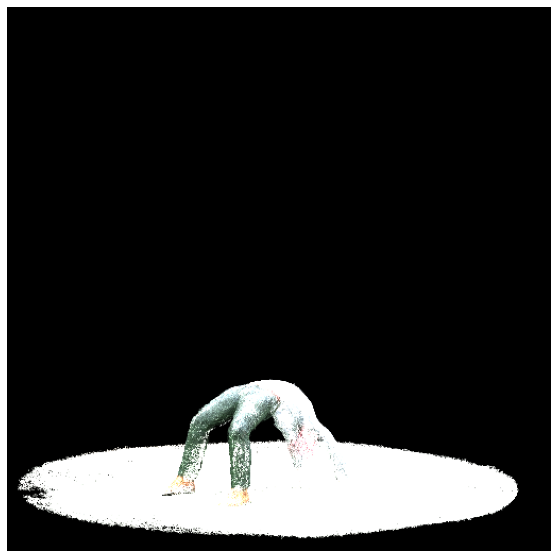

In [5]:
images = renderer(point_cloud)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")